2025-03-24 17:10:34.268008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 17:10:34.277880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742836234.291678  100579 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742836234.295432  100579 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742836234.305693  100579 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

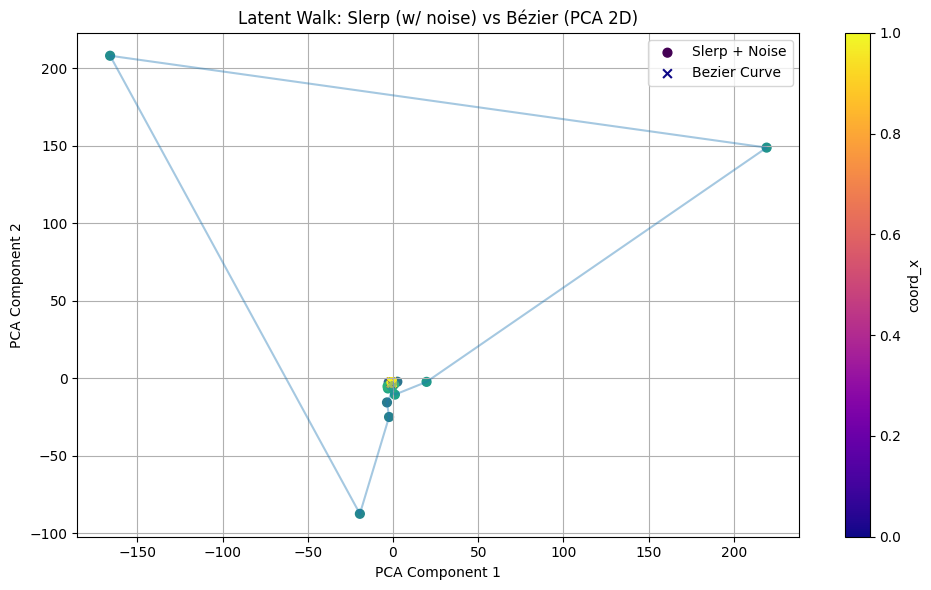

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load GPT-2
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Generate sentences
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
prompt = "The meaning of life is"
output = generator(prompt, max_length=50, num_return_sequences=2)
text1 = output[0]["generated_text"]
text2 = output[1]["generated_text"]

# Token to embeddings
tokens1 = tokenizer(text1, return_tensors="pt")["input_ids"].to(model.device)
tokens2 = tokenizer(text2, return_tensors="pt")["input_ids"].to(model.device)
with torch.no_grad():
    embedding1 = model.get_input_embeddings()(tokens1).squeeze(0)
    embedding2 = model.get_input_embeddings()(tokens2).squeeze(0)

# Pad to equal length
max_len = max(embedding1.shape[0], embedding2.shape[0])
embedding1 = torch.nn.functional.pad(embedding1, (0, 0, 0, max_len - embedding1.size(0)))
embedding2 = torch.nn.functional.pad(embedding2, (0, 0, 0, max_len - embedding2.size(0)))

# Interpolation funcs
def noise_mult(t):
    return np.exp(-((t - 0.5) / 0.2) ** 2)

def get_answer(v0, v1, coord_x=0.0, coord_y=0.5):
    seed = int(coord_x * 1000) + int(coord_y * 1000) * 10000
    torch.manual_seed(seed)
    noise_x = torch.randn_like(v0)
    torch.manual_seed(seed + 1)
    noise_y = torch.randn_like(v0)

    denom = torch.linalg.norm(v0, dim=-1) * torch.linalg.norm(v1, dim=-1)
    denom = torch.clamp(denom, min=1e-8)
    dot = torch.sum(v0 * v1, dim=-1) / denom
    dot = torch.clamp(dot, -1.0, 1.0)
    theta = torch.arccos(dot)
    sin_theta = torch.sin(theta) + 1e-8

    interp = (
        (torch.sin((1 - coord_x) * theta) / sin_theta)[:, None] * v0 +
        (torch.sin(coord_x * theta) / sin_theta)[:, None] * v1
    )

    nm = noise_mult(coord_x)
    return interp + (noise_x + noise_y) * nm

def get_curved_answer(v0, v1, coord_x=0.0, coord_y=0.5):
    direction = v1 - v0
    midpoint = (v0 + v1) / 2
    fake_vec = torch.ones_like(direction)
    perp = fake_vec - (fake_vec * direction).sum(-1, keepdim=True) / (direction.norm(dim=-1, keepdim=True)**2 + 1e-8) * direction
    perp = torch.nn.functional.normalize(perp, dim=-1)

    control_point = midpoint + coord_y * 5.0 * perp
    t = torch.tensor(coord_x).float().to(model.device)
    return (1 - t)**2 * v0 + 2 * (1 - t) * t * control_point + t**2 * v1

# Collect paths
steps = 40
coords_x = np.linspace(0, 1, steps)
slerp_latents, bezier_latents = [], []

for x in coords_x:
    s = get_answer(embedding1, embedding2, coord_x=x, coord_y=0.5).flatten().cpu().numpy()
    b = get_curved_answer(embedding1, embedding2, coord_x=x, coord_y=0.5).flatten().cpu().numpy()
    slerp_latents.append(s)
    bezier_latents.append(b)

# PCA
pca = PCA(n_components=2)
all_latents = np.vstack([slerp_latents, bezier_latents])
latent_2d = pca.fit_transform(all_latents)
slerp_2d = latent_2d[:steps]
bezier_2d = latent_2d[steps:]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(slerp_2d[:, 0], slerp_2d[:, 1], c=coords_x, cmap='viridis', label='Slerp + Noise', s=40)
plt.plot(slerp_2d[:, 0], slerp_2d[:, 1], alpha=0.4)

plt.scatter(bezier_2d[:, 0], bezier_2d[:, 1], c=coords_x, cmap='plasma', label='Bezier Curve', s=40, marker='x')
plt.plot(bezier_2d[:, 0], bezier_2d[:, 1], linestyle='--', alpha=0.4)

plt.title("Latent Walk: Slerp (w/ noise) vs Bézier (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='coord_x')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
